In [1]:
# faceMask hDDM face ratings analysis script: mask analyses of false negatives (failing to ID correct emotion)
# 12/07/20

# note: to be run within python 3.5 environment named "hddm" (from console: 'source activate hddm')
# confirm jupyter notebook is launching from "hddm" environment (see top-right: 'conda env:hddm')

# set up
import numpy as np
print(np.__version__) # should be 1.11.3

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from patsy import dmatrix

import hddm
print(hddm.__version__) # should be 0.6.0

1.11.1
0.6.0


C:\Users\becky\Anaconda3\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
# load hDDM-processed data from CSV file into a NumPy structured array
data = hddm.load_csv('faceMask2_hddm_proc.csv')
                     
# flip 'no' response RTs to be negative
data = hddm.utils.flip_errors(data)

# check dataset
data.head(10)

,subj_idx,block,faceList,emotionRating,trial,stimulus,face,model,ethnicity,sex,expression,mask,response,rt,faceAngry,faceDisgusted,faceFearful,faceHappy,faceSad,faceSurprised
0,lbmmswtrr0mpvov,0,3,surprised,0,_faces/HM08_F_X.jpg,HM08_F_X,HM08,H,M,fearful,baseline,1,2.248290,0,0,100,0,0,0
1,lbmmswtrr0mpvov,0,3,surprised,1,_faces/BM17_R_X.jpg,BM17_R_X,BM17,B,M,surprised,baseline,1,1.122130,0,0,0,0,0,100
2,lbmmswtrr0mpvov,0,3,surprised,2,_faces/WF05_S_X.jpg,WF05_S_X,WF05,W,F,sad,baseline,0,-1.093135,0,0,0,0,100,0
3,lbmmswtrr0mpvov,0,3,surprised,3,_faces/BM17_R_L.jpg,BM17_R_L,BM17,B,M,surprised,lower,1,1.347000,0,0,0,0,0,50
4,lbmmswtrr0mpvov,0,3,surprised,4,_faces/BF10_D_X.jpg,BF10_D_X,BF10,B,F,disgusted,baseline,0,-1.586875,0,100,0,0,0,0
5,lbmmswtrr0mpvov,0,3,surprised,5,_faces/BF15_F_L.jpg,BF15_F_L,BF15,B,F,fearful,lower,1,1.020070,0,0,50,0,0,0
6,lbmmswtrr0mpvov,0,3,surprised,6,_faces/AM07_S_X.jpg,AM07_S_X,AM07,A,M,sad,baseline,0,-1.092280,0,0,0,0,100,0
7,lbmmswtrr0mpvov,0,3,surprised,7,_faces/BF10_D_L.jpg,BF10_D_L,BF10,B,F,disgusted,lower,0,-1.574250,0,50,0,0,0,0
8,lbmmswtrr0mpvov,0,3,surprised,8,_faces/AM07_S_U.jpg,AM07_S_U,AM07,A,M,sad,upper,0,-1.219265,0,0,0,0,50,0
9,lbmmswtrr0mpvov,0,3,surprised,9,_faces/BM16_H_U.jpg,BM16_H_U,BM16,B,M,happy,upper,0,-1.092995,0,0,0,50,0,0


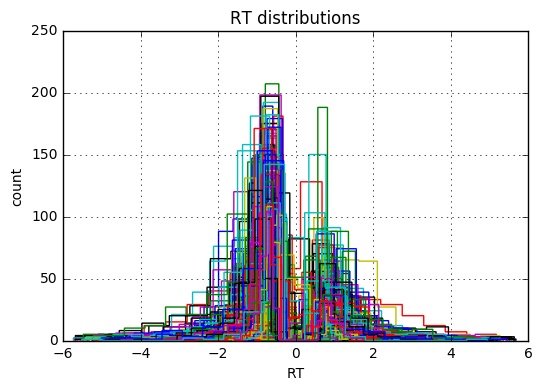

In [3]:
# plot RTs for each participant
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [4]:
# subset dataset by emotion rating type (happy) and facial expression (sad)
hs_data = data.loc[(data['emotionRating'] == 'happy') & (data['expression'] == 'sad')]
hs_data.head(10)

,subj_idx,block,faceList,emotionRating,trial,stimulus,face,model,ethnicity,sex,expression,mask,response,rt,faceAngry,faceDisgusted,faceFearful,faceHappy,faceSad,faceSurprised
215,lbmmswtrr0mpvov,4,6,happy,216,_faces/AF06_S_X.jpg,AF06_S_X,AF06,A,F,sad,baseline,0,-1.403060,0,0,0,0,100,0
220,lbmmswtrr0mpvov,4,6,happy,221,_faces/HM08_S_X.jpg,HM08_S_X,HM08,H,M,sad,baseline,0,-0.517085,0,0,0,0,100,0
223,lbmmswtrr0mpvov,4,6,happy,224,_faces/AF06_S_L.jpg,AF06_S_L,AF06,A,F,sad,lower,0,-0.757060,0,0,0,0,50,0
238,lbmmswtrr0mpvov,4,6,happy,239,_faces/HM08_S_U.jpg,HM08_S_U,HM08,H,M,sad,upper,0,-0.718470,0,0,0,0,50,0
243,lbmmswtrr0mpvov,4,6,happy,244,_faces/AF06_S_U.jpg,AF06_S_U,AF06,A,F,sad,upper,0,-0.844750,0,0,0,0,50,0
245,lbmmswtrr0mpvov,4,6,happy,246,_faces/BF15_S_X.jpg,BF15_S_X,BF15,B,F,sad,baseline,0,-0.605190,0,0,0,0,100,0
248,lbmmswtrr0mpvov,4,6,happy,249,_faces/BF15_S_U.jpg,BF15_S_U,BF15,B,F,sad,upper,0,-0.684705,0,0,0,0,50,0
258,lbmmswtrr0mpvov,4,6,happy,259,_faces/BF15_S_L.jpg,BF15_S_L,BF15,B,F,sad,lower,0,-1.725370,0,0,0,0,50,0
265,lbmmswtrr0mpvov,4,6,happy,266,_faces/HM08_S_L.jpg,HM08_S_L,HM08,H,M,sad,lower,0,-0.861350,0,0,0,0,50,0
486,mr81dhy9r5lxu8r,3,1,happy,164,_faces/BF10_S_X.jpg,BF10_S_X,BF10,B,F,sad,baseline,0,-1.498000,0,0,0,0,100,0


In [5]:
# drop any subjects missing columns in design matrix (otherwise produces error)
hs_data = hs_data[(hs_data.subj_idx != 'dqph4ch0mkofejw') & (hs_data.subj_idx != 'hdn2l3df216jykn') & (hs_data.subj_idx != 'j2qezlblp8v0dh6') & (hs_data.subj_idx != 'me8doxrmo9vj9dx')]

In [6]:
# define model
m_hs = hddm.HDDMRegressor(hs_data, "v ~ C(mask)", bias=True, p_outlier=0.05)

Adding these covariates:
['v_Intercept', 'v_C(mask)[T.lower]', 'v_C(mask)[T.upper]']


C:\Users\becky\Anaconda3\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 5001 of 5000 complete in 45620.7 sec

C:\Users\becky\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


                                       mean        std       2.5q        25q         50q        75q      97.5q       mc err
a                                   2.13733  0.0984353     1.9577    2.07018     2.13233    2.20081    2.35253   0.00700567
a_std                              0.699434  0.0823235   0.555849   0.641244     0.69375   0.750096   0.881082   0.00586098
a_subj.09coqg8hlpux6fe              2.25152   0.608445    1.29684    1.78754     2.18696    2.61726    3.63895    0.0229163
a_subj.0b3t2skj9mlhbkn              2.28266   0.645537    1.23855    1.83011     2.20419    2.65278    3.77562    0.0244759
a_subj.0bcg7mtj2n1jjw9              2.97786    0.65052    1.92844    2.50454     2.89253    3.37684    4.44051    0.0191438
a_subj.0s53r30oouek89b              2.58155   0.492919    1.74181    2.22402     2.53187    2.88491    3.65242    0.0090828
a_subj.0uj9gbhag3o1w1v              2.22463    0.71147    1.11303    1.71153     2.13338    2.62352    3.83244    0.0311893
a_subj.1

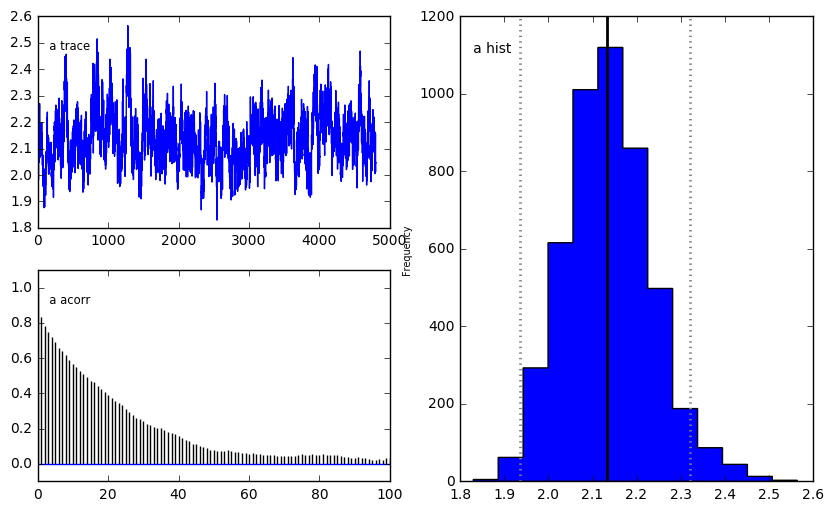

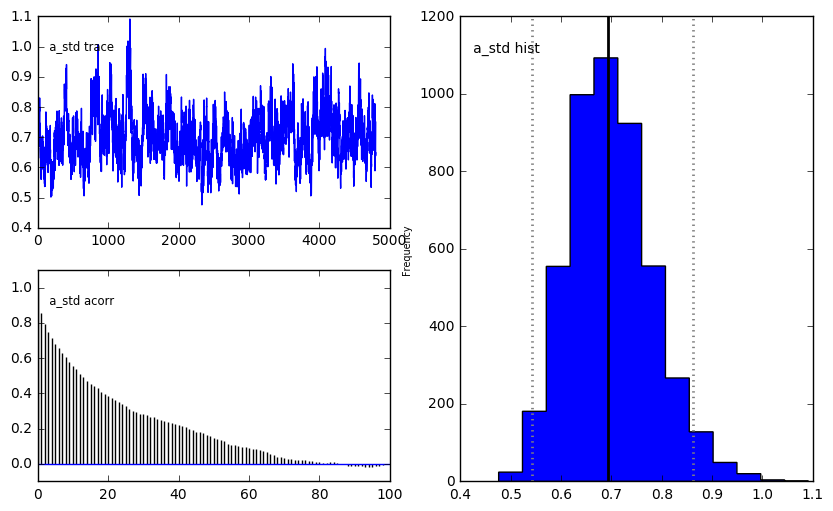

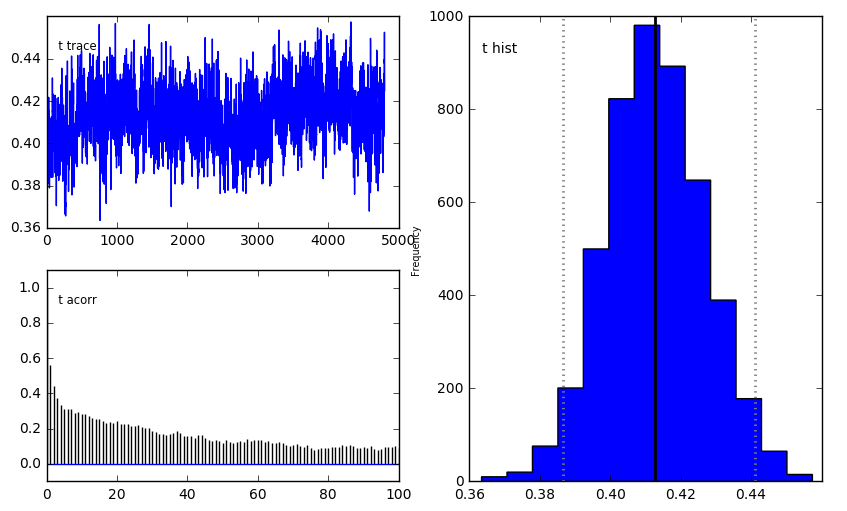

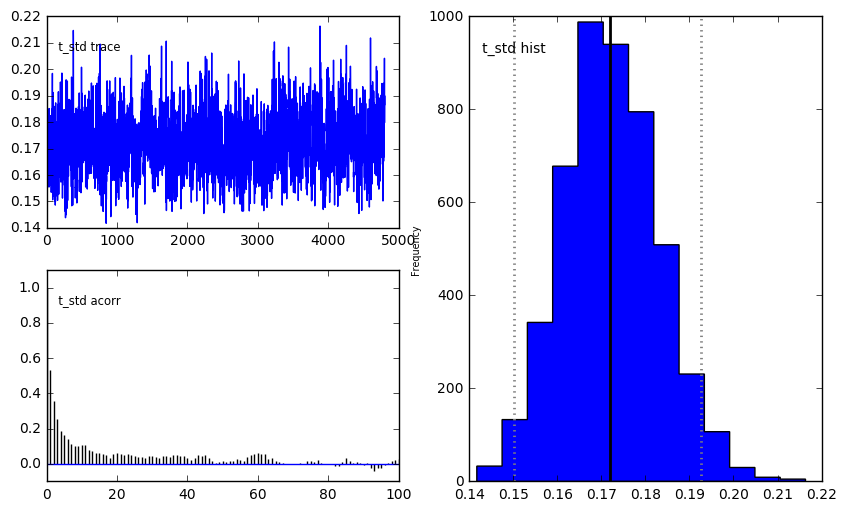

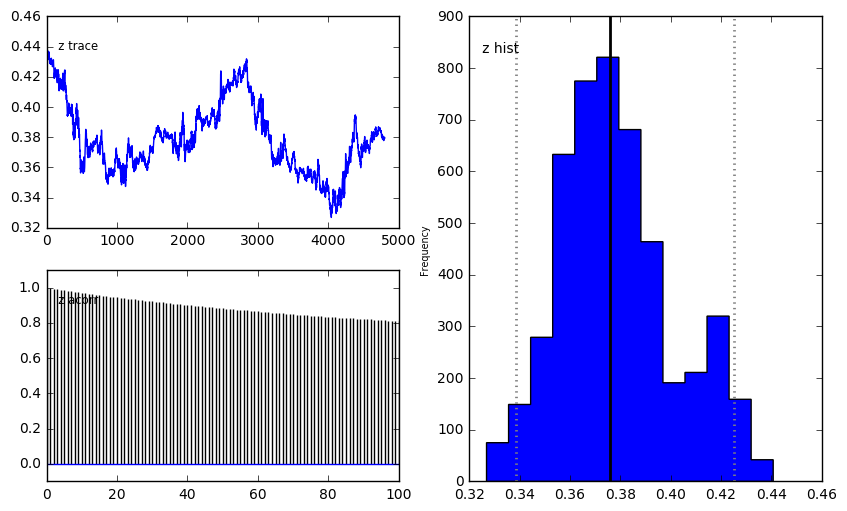

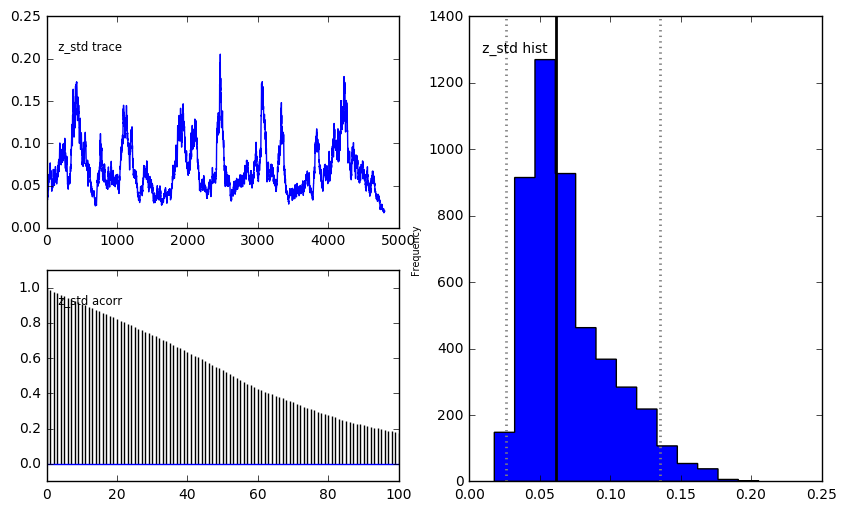

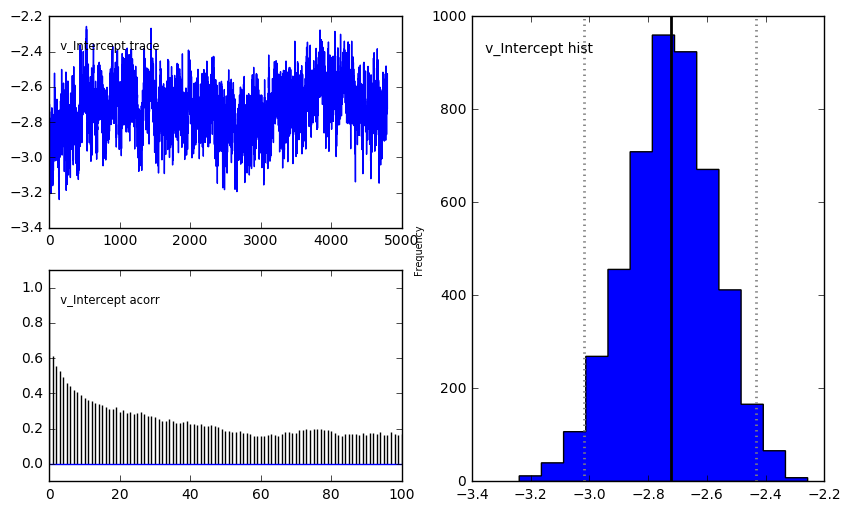

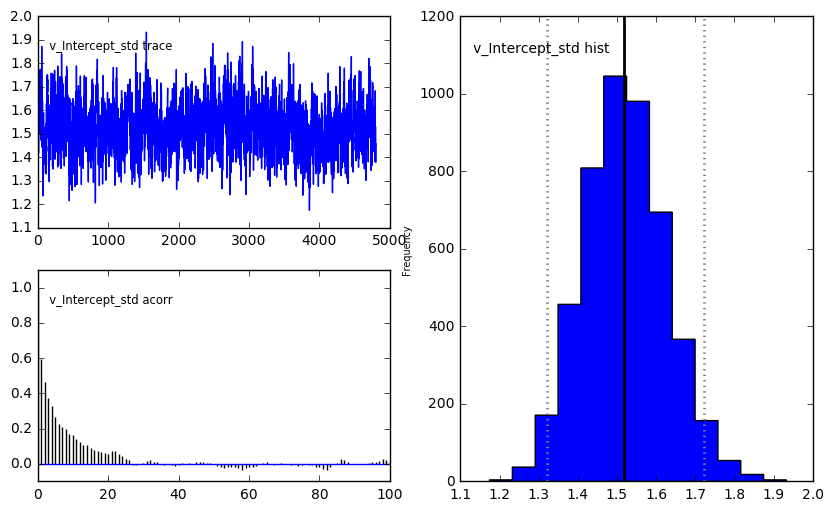

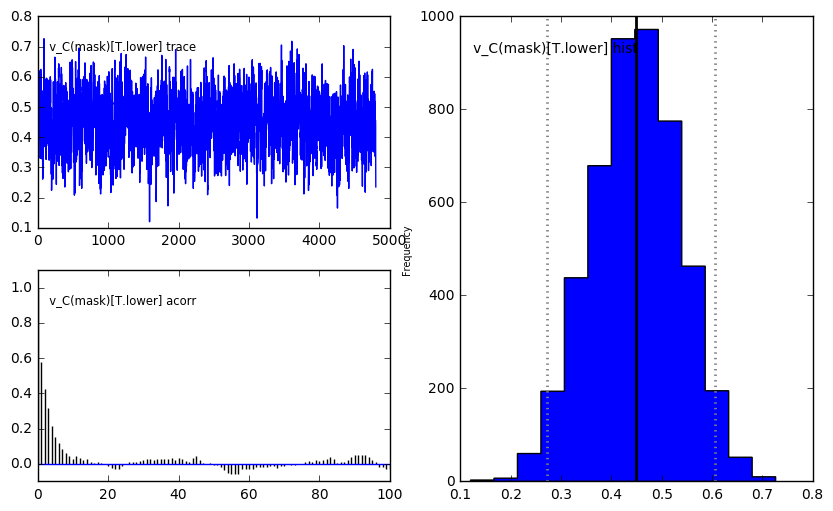

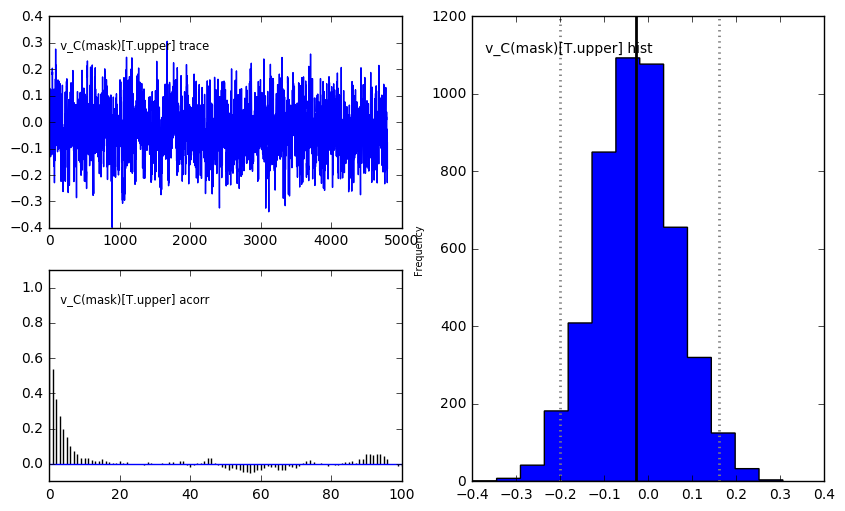

In [7]:
# run model
m_hs.sample(5000, burn=200, dbname='traces.db', db='pickle')
m_hs.print_stats()
m_hs.plot_posteriors()

C:\Users\becky\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


                                       mean        std      2.5q        25q  \
a                                   2.13733  0.0984353    1.9577    2.07018   
a_std                              0.699434  0.0823235  0.555849   0.641244   
a_subj.09coqg8hlpux6fe              2.25152   0.608445   1.29684    1.78754   
a_subj.0b3t2skj9mlhbkn              2.28266   0.645537   1.23855    1.83011   
a_subj.0bcg7mtj2n1jjw9              2.97786    0.65052   1.92844    2.50454   
a_subj.0s53r30oouek89b              2.58155   0.492919   1.74181    2.22402   
a_subj.0uj9gbhag3o1w1v              2.22463    0.71147   1.11303    1.71153   
a_subj.17nzn4k8r1qkmrn              2.21845   0.615268   1.21891    1.78741   
a_subj.1fdkw2qjx3hc3lk              1.88326   0.569193   1.00703    1.47082   
a_subj.1mla0dmotqefnav              2.94958   0.534222   2.10102    2.57317   
a_subj.23hr9tl84h3zhw3              1.95529   0.573646    1.0437    1.53892   
a_subj.27muqwvalwne26r              2.16164   0.5981

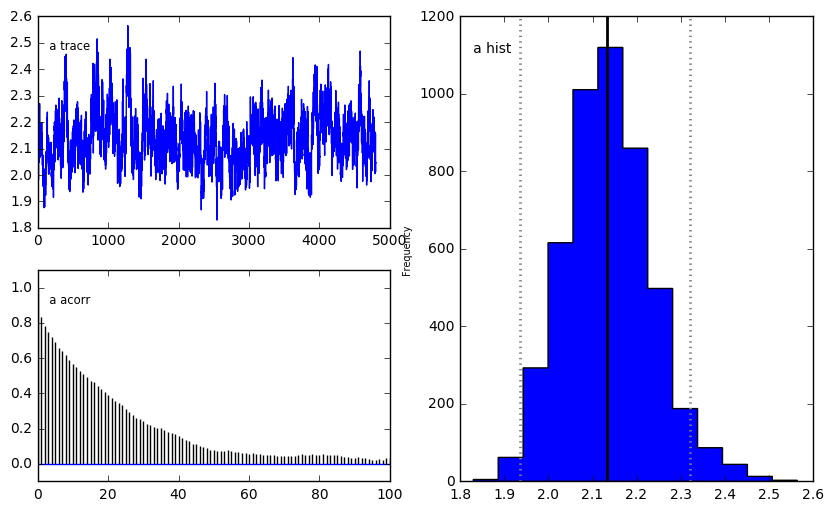

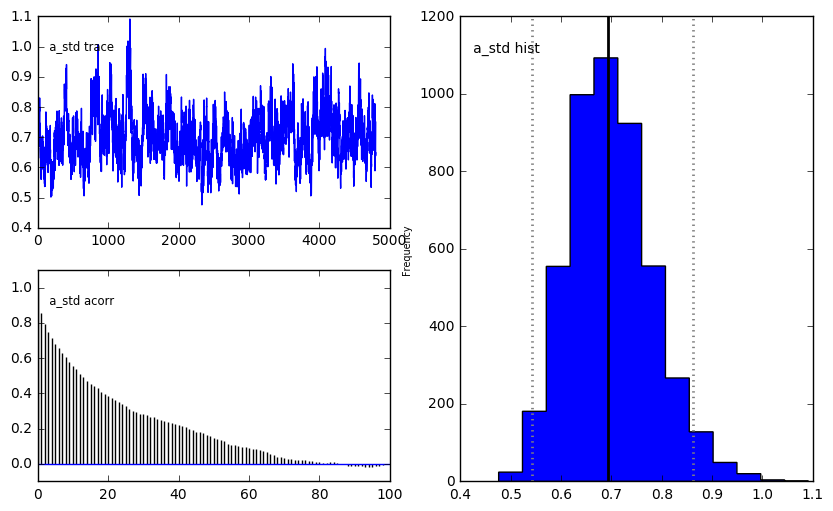

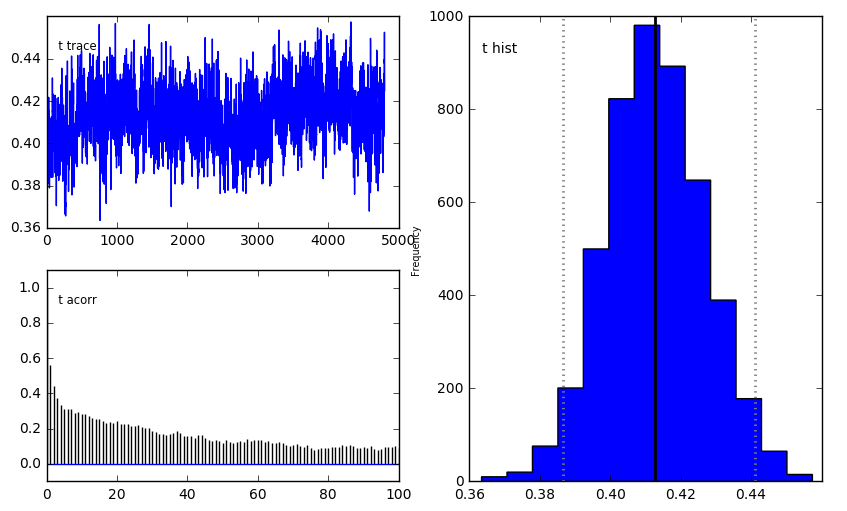

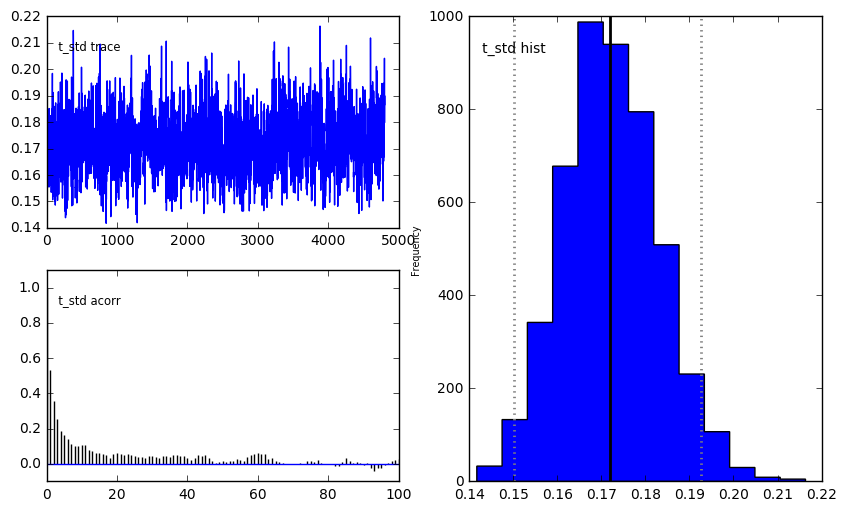

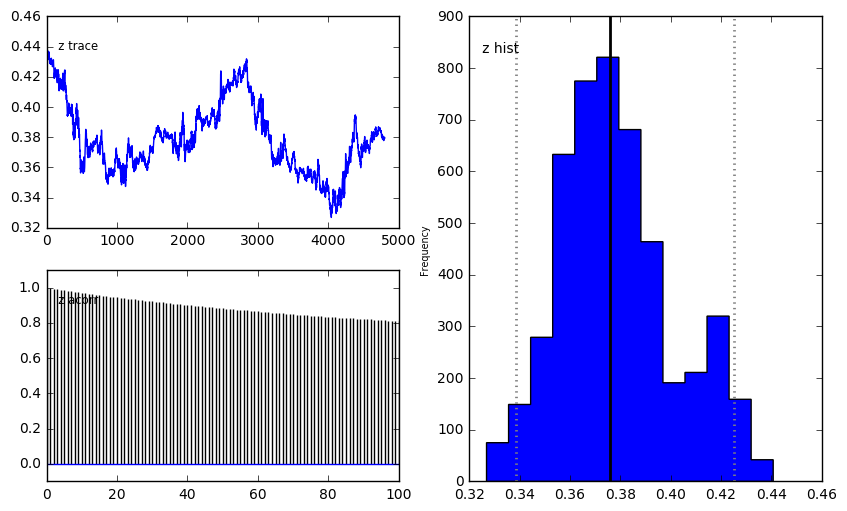

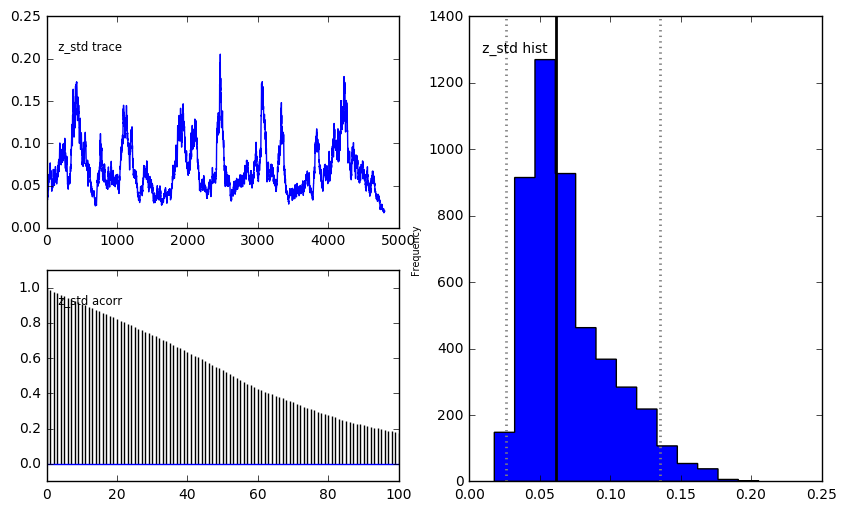

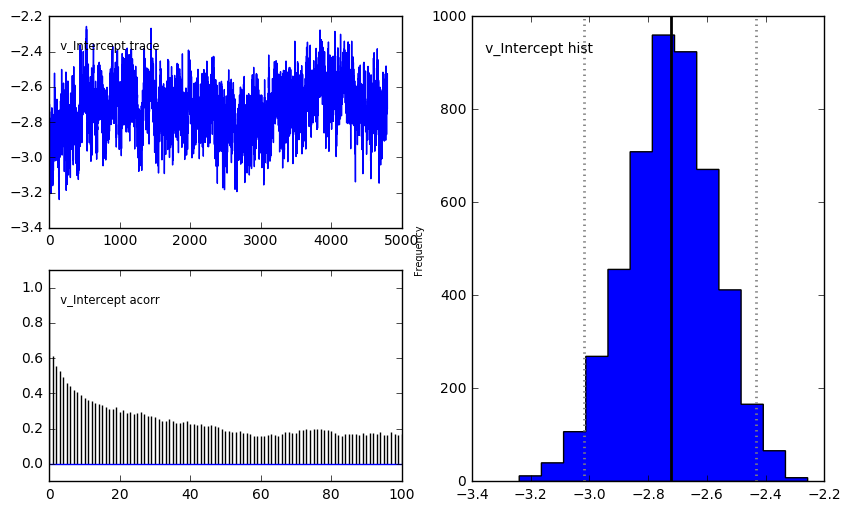

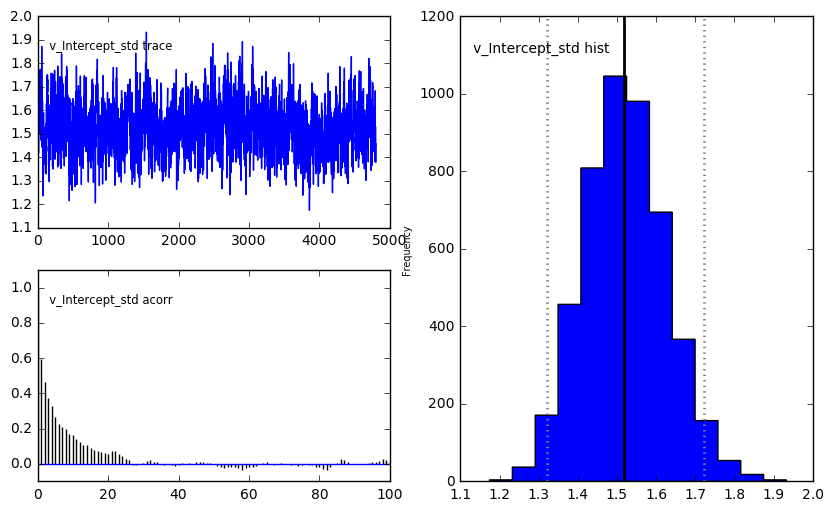

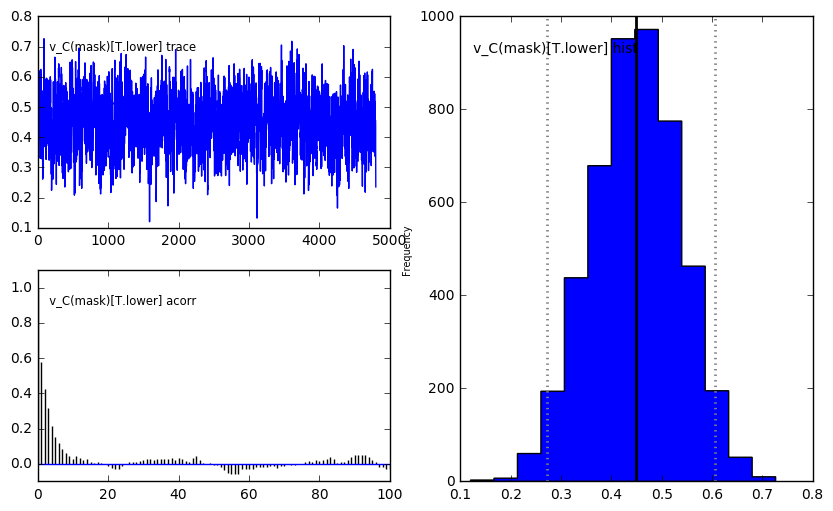

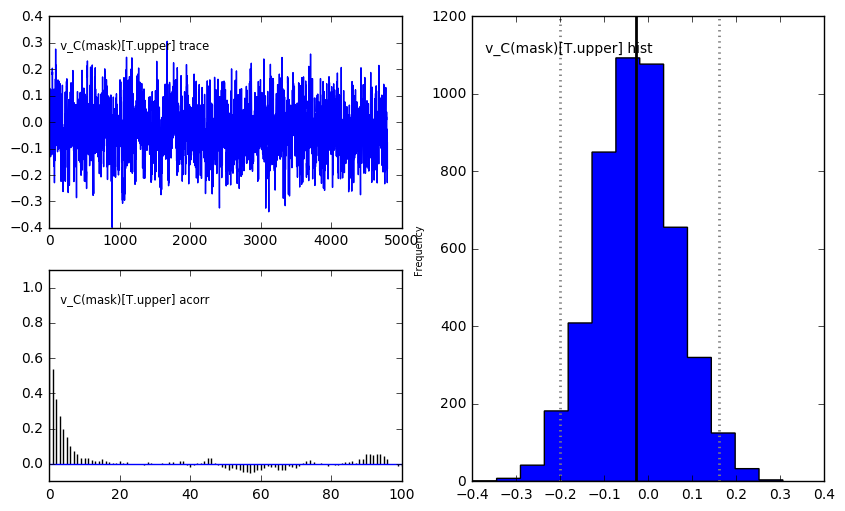

In [16]:
# save model stats
hs_stats = m_hs.gen_stats()
print(hs_stats)
hs_stats.to_csv('hs_5000/faceMask_hddm_drift_maskFalsePositives_hs_5000.csv', index=True)

# save model posterior plots
m_hs.plot_posteriors(path='hs_5000/_posteriors', save=True)

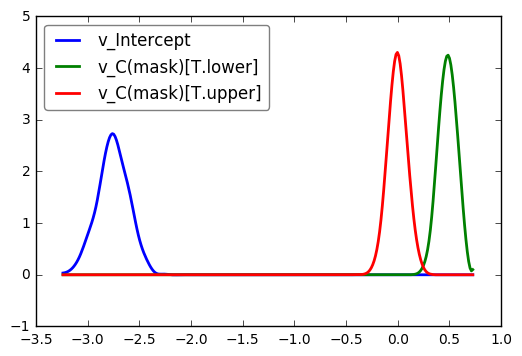

In [17]:
# plot model posteriors by mask
hs_v_none, hs_v_lower, hs_v_upper = m_hs.nodes_db.node[["v_Intercept", "v_C(mask)[T.lower]", "v_C(mask)[T.upper]"]]
hddm.analyze.plot_posterior_nodes([hs_v_none, hs_v_lower, hs_v_upper])
plt.savefig('hs_5000/faceMask_hddm_drift_maskFalsePositives_hs_5000_v_mask.pdf')

In [18]:
## estimate probabilities that mask coefficient posteriors differ from 0
# note that comparison condition coefficients (i.e. lower/upper) are *relative to* baseline condition (i.e. no mask)
# for lower/upper, =0 means no change from baseline, <0 means less than baseline, and >0 means greater than baseline
# for no mask, =0 means null drift, <0 means negative drift, and >0 means positive drift
print("P(hs_v_none < 0) = ", (hs_v_none.trace() < 0).mean())
print("P(hs_v_lower < 0) = ", (hs_v_lower.trace() < 0).mean())
print("P(hs_v_upper > 0) = ", (hs_v_upper.trace() > 0).mean())

# estimate probability that lower and upper mask coefficient posteriors differ
print("P(hs_v_lower < hs_v_upper) = ", (hs_v_lower.trace() < hs_v_upper.trace()).mean())

P(hs_v_none < 0) =  1.0
P(hs_v_lower < 0) =  0.0
P(hs_v_upper > 0) =  0.384166666667
P(hs_v_lower < hs_v_upper) =  0.0
